In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix



2025-06-21 12:14:28.351252: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 12:14:28.360889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 12:14:28.372477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 12:14:28.375883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 12:14:28.384844: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df=pd.read_csv(r'combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [3]:
def data_info(data):
    cols=[]
    unique_val=[]
    n_uniques=[]
    dtypes=[]
    nulls=[]
    for col in data.columns:
        cols.append(col)
        dtypes.append(data[col].dtype)
        n_uniques.append(data[col].nunique())
        unique_val.append(data[col].unique())
        nulls.append(data[col].isna().sum())

    return pd.DataFrame({"Col":cols,"dtype":dtypes,"n_uniques":n_uniques,"Unique Values":unique_val,"Nulls":nulls})

In [4]:
data_info(df)

,Col,dtype,n_uniques,Unique Values,Nulls
0,label,int64,2,"[1, 0]",0
1,text,object,83446,[ounce feather bowl hummingbird opec moment al...,0


In [5]:
df.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
df.duplicated().sum()

0

In [7]:
df.shape

(83448, 2)

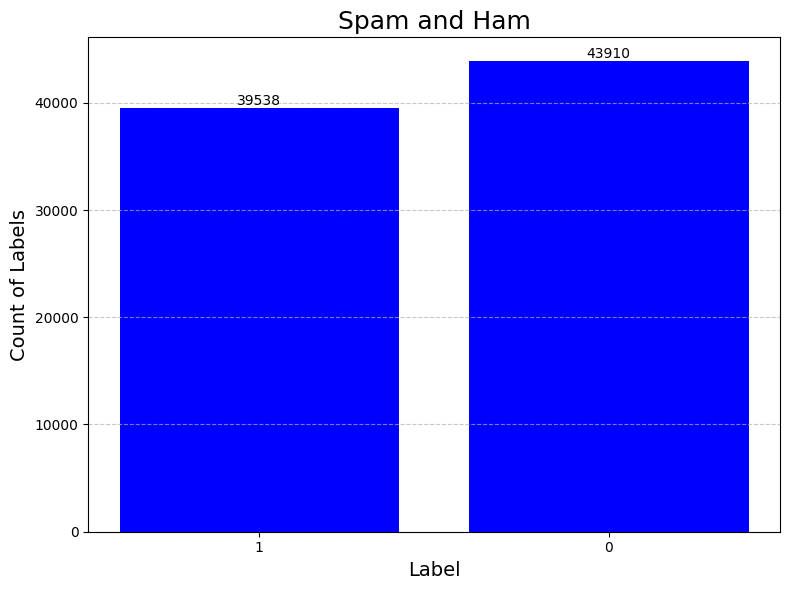

In [8]:
import matplotlib.pyplot as plt

labels = df['label'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(labels.index, labels.values, color='blue')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')


plt.title('Spam and Ham', fontsize=18)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count of Labels', fontsize=14)


plt.xticks(ticks=range(len(labels.index)), labels=labels.index)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
df["length"] = df["text"].apply(len)
print(df["length"])


0         148
1         808
2        2235
3         592
4        1362
         ... 
83443    2589
83444     616
83445     534
83446    2113
83447     223
Name: length, Length: 83448, dtype: int64


In [10]:
from textblob import TextBlob
def get_polarity(text):
  textblob = TextBlob(str(text.encode("utf-8")))
  pol = textblob.sentiment.polarity
  return pol
def get_subjectivity(text):
  textblob = TextBlob(str(text.encode("utf-8")))
  pol = textblob.sentiment.subjectivity
  return pol

df["Polarity"] = df["text"].apply(get_polarity)
df["Subjectivity"] = df["text"].apply(get_subjectivity)

print(df[['length', 'Polarity', 'Subjectivity']].describe())



              length      Polarity  Subjectivity
count   83448.000000  83448.000000  83448.000000
mean     1662.952725      0.118250      0.442449
std      4178.578068      0.166880      0.195201
min         1.000000     -1.000000      0.000000
25%       449.000000      0.003846      0.359012
50%       879.000000      0.107407      0.452952
75%      1861.000000      0.206667      0.541667
max    598705.000000      1.000000      1.000000


In [11]:
df.head()

,label,text,length,Polarity,Subjectivity
0,1,ounce feather bowl hummingbird opec moment ala...,148,-0.600000,1.000000
1,1,wulvob get your medircations online qnb ikud v...,808,0.135714,0.375000
2,0,computer connection from cnn com wednesday es...,2235,0.226852,0.306481
3,1,university degree obtain a prosperous future m...,592,0.033333,0.075000
4,0,thanks for all your answers guys i know i shou...,1362,0.038542,0.528819


In [12]:
df = df[['label', 'text']]

In [13]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [14]:
def clean_text(texts):
    texts=re.sub('(#|@)\w*',"",texts)
    texts=re.sub("https?:\/\/\S+","",texts)
    texts=re.sub("(\?|!)+"," ",texts)
    texts=re.sub("\s\d+\s","",texts)
    texts=re.sub("(\.|\,)+","",texts)
    texts=re.sub("^\s+","",texts)
    texts = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', texts)
    texts = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', texts)
    texts = re.sub(r'([a-z])([A-Z])', r'\1 \2', texts)
    texts=re.sub("\s+$","",texts)
    text = texts.strip()
    return texts

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\/'
<>:4: SyntaxWarning: invalid escape sequence '\?'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\/'
<>:4: SyntaxWarning: invalid escape sequence '\?'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_92036/351051685.py:2: SyntaxWarning: invalid escape sequence '\w'
  texts=re.sub('(#|@)\w*',"",texts)
/tmp/ipykernel_92036/351051685.py:3: SyntaxWarning: invalid escape sequence '\/'
  texts=re.sub("https?:\/\/\S+","",texts)
/tmp/ipykernel_92036/351051685.py:4: SyntaxWarning: invali

In [15]:
df['text'] = df['text'].apply(clean_text)

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akshita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = stopwords.words('english')
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [18]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/akshita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akshita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
import nltk
print(nltk.data.find('tokenizers/punkt'))

/home/akshita/nltk_data/tokenizers/punkt


In [20]:
import os
os.environ['NLTK_DATA'] = '/home/akshita/nltk_data'

In [21]:
import nltk
nltk.download('punkt', download_dir='/home/akshita/nltk_data')

[nltk_data] Downloading package punkt to /home/akshita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
import nltk
print(nltk.data.find('tokenizers/punkt'))

/home/akshita/nltk_data/tokenizers/punkt


In [24]:
from nltk.stem import WordNetLemmatizer
import re

wnl = WordNetLemmatizer()
corpus = []
for text in df['text']:
    # Use regex to extract words (only alphabetic)
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    # Remove stopwords and lemmatize
    words = [wnl.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    corpus.append(text)

In [25]:
corpus[1]

'wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pay mediecines ap painkiller drug improve quality life weight reducing tablet many escapenumber worse mediucine cost lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber'

In [26]:
corpus[2]

'computer connection cnn com wednesday escapenumber may escapenumber escapenumber escapenumber escapenumber pm edt report next generation toy read brain wave google expands personalization youtube win webby old fashioned rabbit ear laptop review next generation toy read brain wave startup company aim add realistic element video game using brain wave reading technology help game developer make gaming realistic http www cnn com escapenumber tech fun game escapenumber escapenumber mind reading toy ap index html google expands personalization google stepping effort allow user personalize search web http www cnn com escapenumber tech internet escapenumber escapenumber google personalization reut index html youtube win webby co founder youtube among winner annual webby online achievement award http www cnn com escapenumber tech internet escapenumber escapenumber webby award ap index html old fashioned rabbit ear consumer spending thousand dollar lcd plasma tv hooking escapenumber antenna htt

In [27]:
cv = TfidfVectorizer(max_features=2500)

x = cv.fit_transform(corpus).toarray()
y = df['label']

print(x.shape)
print(y.shape)



(83448, 2500)
(83448,)


In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=45)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(66758, 2500)
(66758,)
(16690, 2500)
(16690,)


In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion = 'gini', max_depth = 7, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 180)
rfc.fit(x_train, y_train)

y_pred5 = rfc.predict(x_test)

acc5=accuracy_score(y_test,y_pred5)


In [ ]:
print("Training accuracy score of the model is:",accuracy_score(y_train, rfc.predict(x_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred5)*100,"%")

Training accuracy score of the model is: 87.76326432787081 %
Testing accuracy score of the model is: 87.48951467944877 %


In [31]:
model1 = GaussianNB()
model1.fit(x_train, y_train)
y_pred1 = model1.predict(x_test)
acc1=accuracy_score(y_test,y_pred1)

In [ ]:
print("Training accuracy score of the model is:",accuracy_score(y_train, model1.predict(x_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred1)*100,"%")

Training accuracy score of the model is: 95.8102399712394 %
Testing accuracy score of the model is: 95.65608148591971 %


In [33]:
model2=MultinomialNB()
model2.fit(x_train,y_train)
y_pred2=model2.predict(x_test)
acc2=accuracy_score(y_test,y_pred2)

In [34]:
print("Training accuracy score of the model is:",accuracy_score(y_train, model2.predict(x_train))*100,"%")
print("Testing accuracy score of the model is:",accuracy_score(y_test,y_pred2)*100,"%")

Training accuracy score of the model is: 95.37883100152791 %
Testing accuracy score of the model is: 95.5122828040743 %


In [35]:
import pickle  

model_filename = "saved_model.pkl" 
tfidf_filename="saved_tfidf.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model1, file)
with open(tfidf_filename, 'wb') as file:
    pickle.dump(cv, file)
print(f"Model saved to: {model_filename}")
print(f"TF-IDF vectorizer saved to: {tfidf_filename}")

Model saved to: saved_model.pkl
TF-IDF vectorizer saved to: saved_tfidf.pkl


In [36]:
import pickle
import re


with open("saved_model.pkl", "rb") as file:
    model = pickle.load(file)

with open("saved_tfidf.pkl", "rb") as file:
    tfidf = pickle.load(file)

def clean_text(texts):
    texts = re.sub(r'(#|@)\w*', '', texts)
    texts = re.sub(r'https?://\S+|www\.\S+', '', texts)
    texts = re.sub(r'(\?|!)+', ' ', texts)
    texts = re.sub(r'\s\d+\s', ' ', texts)
    texts = re.sub(r'[\.,]+', '', texts)
    texts = re.sub(r'^\s+', '', texts)
    texts = re.sub(r'\s+$', '', texts)
    texts = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', texts)
    texts = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', texts)
    texts = re.sub(r'([a-z])([A-Z])', r'\1 \2', texts)
    texts = re.sub(r'\s+', ' ', texts)
    return texts.strip()
email = "Just a quick reminder about our meeting scheduled for tomorrow at 10:00 AM. Let me know if you need to reschedule.Best regards,Sarah"
cleaned_email = clean_text(email)


X_input = tfidf.transform([cleaned_email]).toarray()


prediction = model.predict(X_input)


label = "Spam" if prediction[0] == 1 else "Ham"
print(f"Prediction: {label}")

Prediction: Ham


In [37]:
import pickle
import re


with open("saved_model.pkl", "rb") as file:
    model = pickle.load(file)

with open("saved_tfidf.pkl", "rb") as file:
    tfidf = pickle.load(file)

def clean_text(texts):
    texts = re.sub(r'(#|@)\w*', '', texts)
    texts = re.sub(r'https?://\S+|www\.\S+', '', texts)
    texts = re.sub(r'(\?|!)+', ' ', texts)
    texts = re.sub(r'\s\d+\s', ' ', texts)
    texts = re.sub(r'[\.,]+', '', texts)
    texts = re.sub(r'^\s+', '', texts)
    texts = re.sub(r'\s+$', '', texts)
    texts = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', texts)
    texts = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', texts)
    texts = re.sub(r'([a-z])([A-Z])', r'\1 \2', texts)
    texts = re.sub(r'\s+', ' ', texts)
    return texts.strip()

emails = [
    "Just a quick reminder about our meeting scheduled for tomorrow at 10:00 AM. Let me know if you need to reschedule. Best regards, Sarah",
    "WIN a brand new car! Click here now and claim your free prize!!!",
    "Please see the attached invoice for your recent order. Contact us if you have any questions.",
    "Urgent: Your PayPal account has been suspended. Click here to verify your identity.",
    "Hi! I hope you're having a great week. Just checking in."
]


for i, email in enumerate(emails):
    cleaned_email = clean_text(email)
    X_input = tfidf.transform([cleaned_email]).toarray()
    prediction = model.predict(X_input)
    label = "Spam" if prediction[0] == 1 else "Ham"
    print(f"Email {i+1}: {label}")



Email 1: Ham
Email 2: Spam
Email 3: Ham
Email 4: Spam
Email 5: Ham
